<h2>Pneumonia classification using CNN (Convolutional Neural Network).In this notebook we will experiment with threshold values. 

<br><br>Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically, symptoms include some combination of productive or dry cough, chest pain, fever and difficulty breathing. </h2>

<h3> Learn more from: <a href='https://www.who.int/news-room/fact-sheets/detail/pneumonia'>World Health Organization</a> </h3>
<br>Accuracy on testing set: 0.9104095563139932
<br>Precision on testing set: 0.9148936170212766
<br>Recall on testing set: 0.7962962962962963
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg/1200px-Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg' alt='Pneumonia' height='800' width='300'> </center>
<p>Image Source: Wikipedia</p> 

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

<h2>Process the images and resize them to the preferred size </h2>

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

<h2>Preparing the training and testing data</h2>

In [3]:
train = get_training_data('chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\sandr\AppData\Local\Temp/ipykernel_9664/4037217275.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [4]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


<h2>Visualize training images</h2>

PNEUMONIA


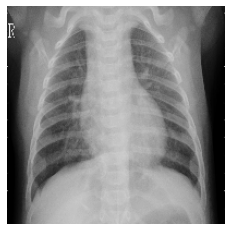

In [5]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

<h2 >We are incoprating the validation data into the training data because it does not contain enough examples. </h2>

In [6]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [7]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data augmentation 

In [8]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

<h2 >CNN (Convolutional Neural Network) </h2>
Image source: https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png

![](https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png)

In [9]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 256)     2560      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 256)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 256)     400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      147520    
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
375/375 [==============================] - 1030s 3s/step - loss: 0.6467 - acc: 0.6995 - val_loss: 0.7833 - val_acc: 0.7407
Epoch 2/10
375/375 [==============================] - 943s 3s/step - loss: 0.5041 - acc: 0.7547 - val_loss: 0.4483 - val_acc: 0.7791
Epoch 3/10
375/375 [==============================] - 939s 3s/step - loss: 0.4474 - acc: 0.7828 - val_loss: 0.3272 - val_acc: 0.8719
Epoch 4/10
375/375 [==============================] - 916s 2s/step - loss: 0.4005 - acc: 0.8102 - val_loss: 0.3018 - val_acc: 0.8613
Epoch 5/10
375/375 [==============================] - 917s 2s/step - loss: 0.3846 - acc: 0.8284 - val_loss: 0.3019 - val_acc: 0.8666
Epoch 6/10
375/375 [==============================] - 904s 2s/step - loss: 0.3412 - acc: 0.8537 - val_loss: 0.2528 - val_acc: 0.9050
Epoch 7/10
375/375 [==============================] - 919s 2s/step - loss: 0.3371 - acc: 0.8489 - val_loss: 0.2837 - val_acc: 0.8954
Epoch 8/10
375/375 [==============================] - 915s 2s/step -

In [12]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 89s 2s/step - loss: 0.2821 - acc: 0.8729


[0.28213170170783997, 0.8728668689727783]

<h2>Visualizing our training progress</h2>

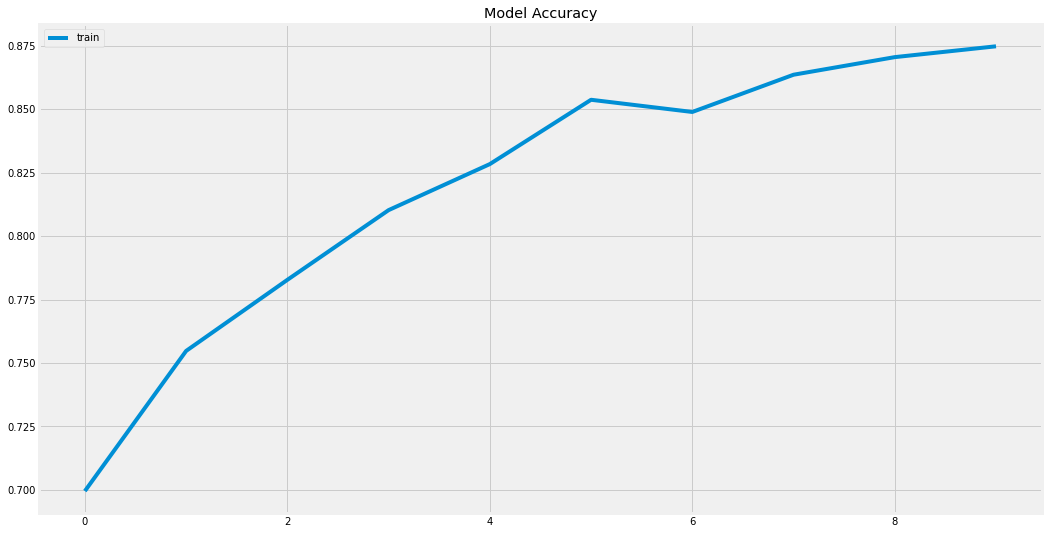

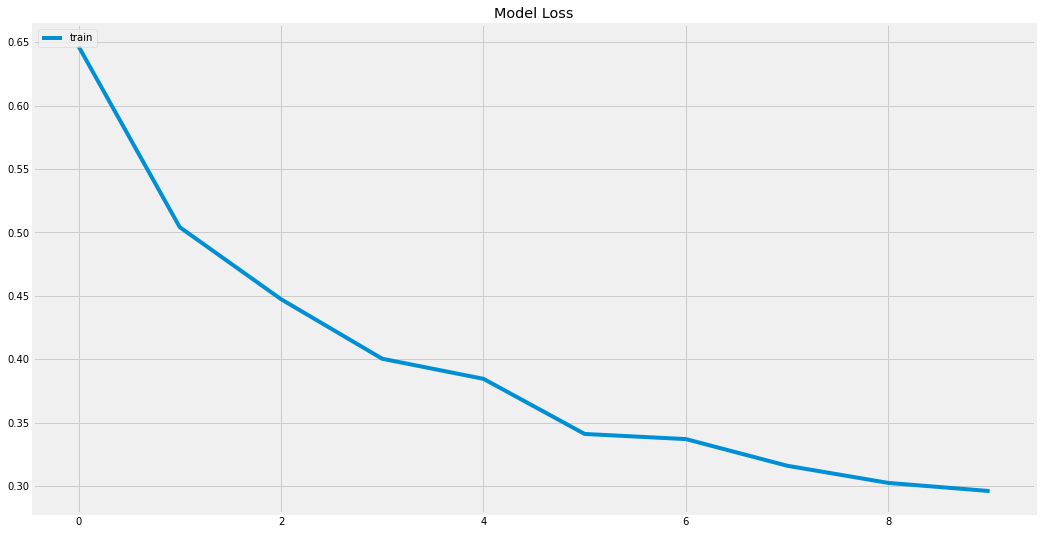

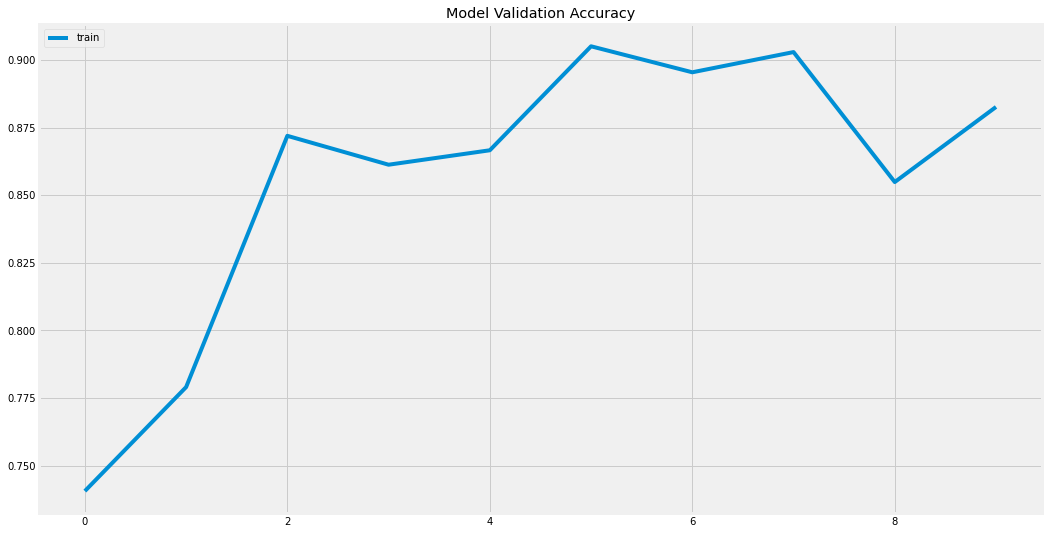

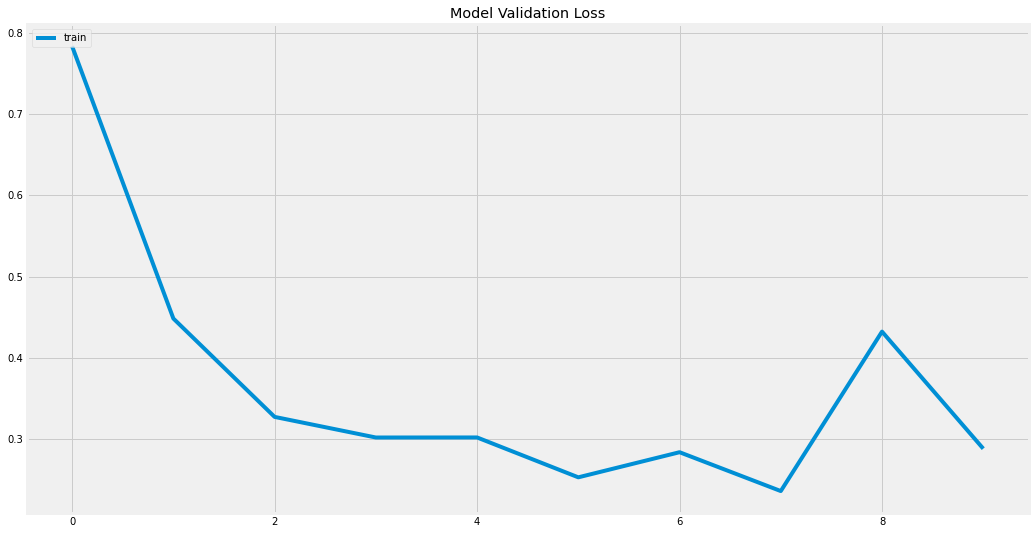

In [13]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

<h2>Prepare data for precision vs. recall and ROC</h2>

In [14]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

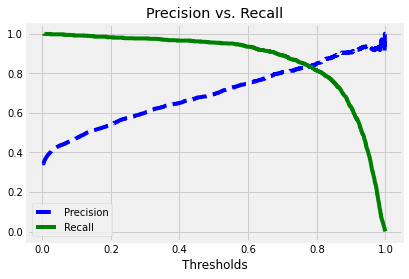

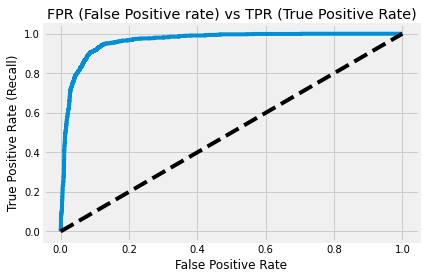

In [15]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [16]:
predictions = model.predict(X_test)

<h2>Set thresholds for our model, we want the results to be precise while not sacrificing too much recall </h2>

In [17]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [18]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9146757679180887
Precision on testing set: 0.9209726443768997
Recall on testing set: 0.8037135278514589


<h2>Plotting the confusion matrix. Here is how we interpet one. </h2>

Image source: https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png

![](https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png)

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

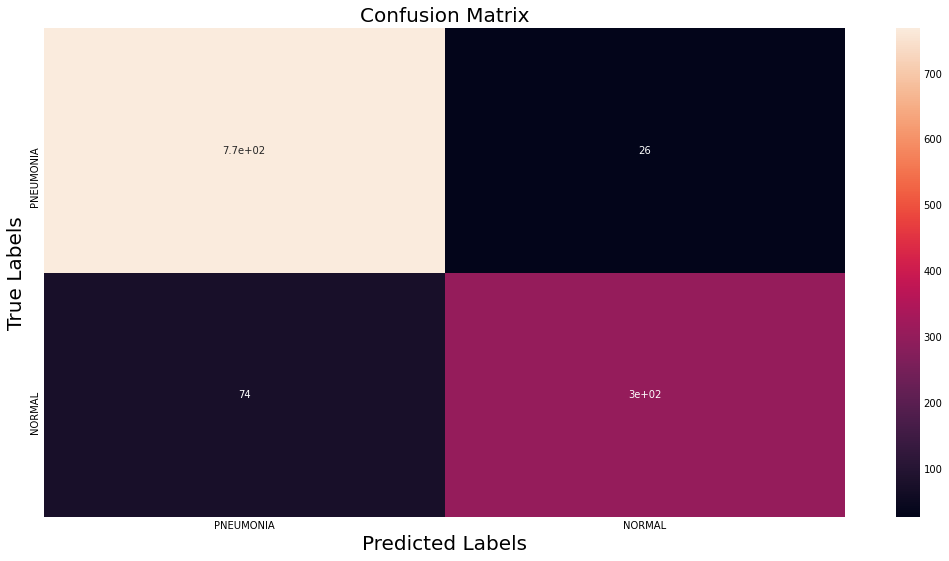

In [19]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

<h2>View some results from a sample of 25 images</h2>

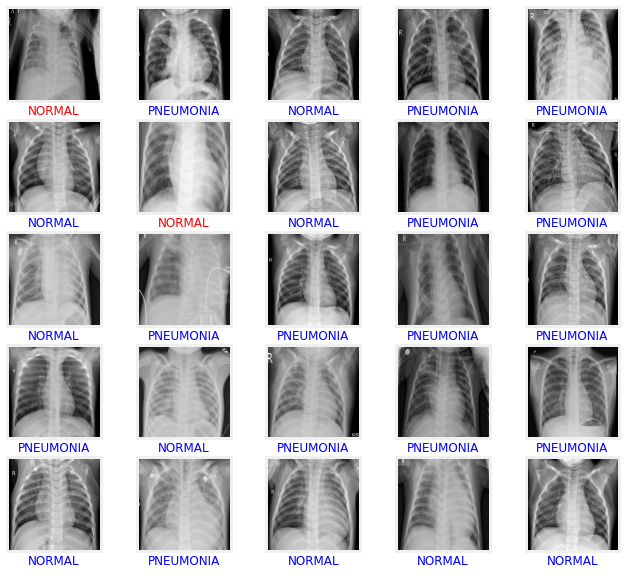

In [20]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

<h2>Download the model</h2>

In [21]:
 model.save('pneumonia_detection_ai_version_3.h5')